# Assignment: Visualization
### `! git clone https://github.com/ds3001f25/visualization_assignment.git`
### Do Q1 and Q2.

**Q1.** Write your own function to make a kernel density plot.

- The user should pass in a Pandas series or Numpy array.
- The default kernel should be Gaussian, but include the uniform/bump and Epanechnikov as alternatives.
- The default bandwidth should be the Silverman plug-in, but allow the user to specify an alternative.
- You can use Matplotlib or Seaborn's `.lineplot`, but not an existing function that creates kernel density plots.

You will have to make a lot of choices and experiment with getting errors. Embrace the challenge and track your choices in the comments in your code.

Use the pretrail data set from class to show that your function works, and compare it with the Seaborn `kdeplot`.

We covered the Gaussian,
$$
k(z) = \dfrac{1}{\sqrt{2\pi}}e^{-z^2/2}
$$
and uniform 
$$
k(z) = \begin{cases} 
\frac{1}{2}, & |z| \le 1 \\
0, & |z|>1
\end{cases}
$$
kernels in class, but the Epanechnikov kernel is 
$$
k(z) = \begin{cases} 
\frac{3}{4} (1-z^2), & |z| \le 1 \\
0, & |z|>1.
\end{cases}
$$

In order to make your code run reasonably quickly, consider using the `pdist` or `cdist` functions from SciPy to make distance calculations for arrays of points. The other leading alternative is to thoughtfully use NumPy's broadcasting features. Writing `for` loops will be slow, but that's fine.

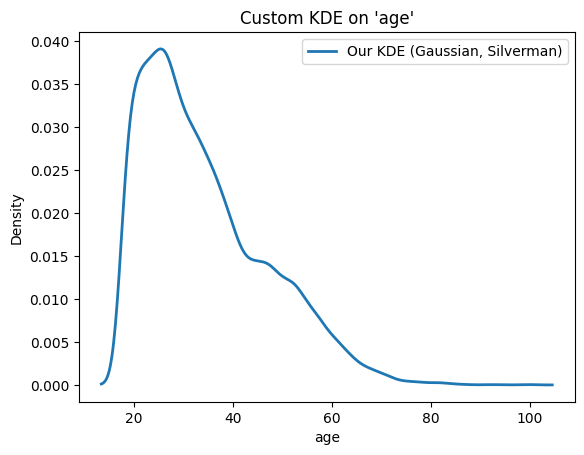

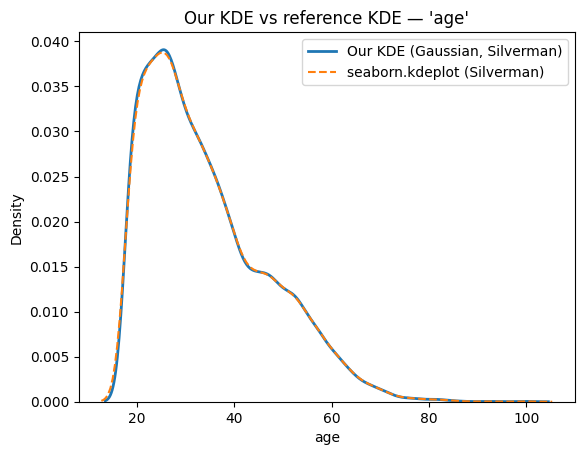

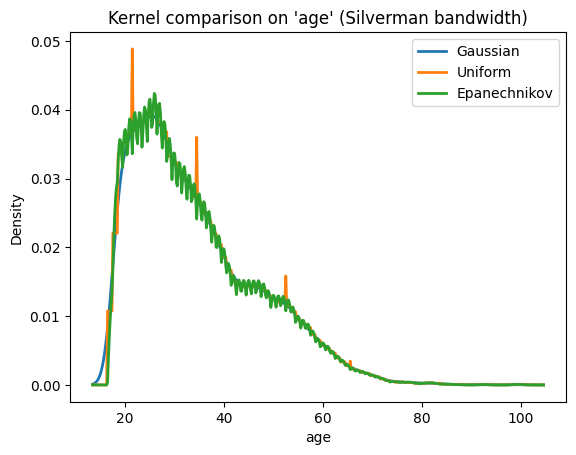

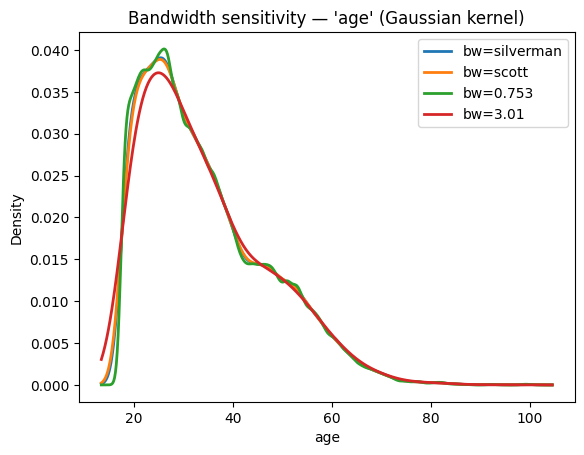

In [3]:
# Engineering choices:
# - Vectorization: use NumPy broadcasting to evaluate K((x - xi)/h) on a grid
#   in one shot (shape (m, n)).
# - Robust scale: use IQR-based scale in Silverman bandwidth to handle outliers.

from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Union, Optional

try:
    import seaborn as sns
    _HAVE_SEABORN = True
except Exception:
    _HAVE_SEABORN = False

try:
    from scipy.stats import gaussian_kde
    _HAVE_SCIPY = True
except Exception:
    _HAVE_SCIPY = False


ArrayLike1D = Union[np.ndarray, pd.Series, list, tuple]


def _as_1d_array(x: ArrayLike1D) -> np.ndarray:
    """Coerce to 1D float array, drop NaNs; raise if empty."""
    arr = np.asarray(x, dtype=float).ravel()
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        raise ValueError("Input has no valid (non-NaN) values.")
    return arr


def _iqr(a: np.ndarray) -> float:
    """Interquartile range via percentiles (robust scale)."""
    q75, q25 = np.percentile(a, [75, 25])
    return float(q75 - q25)


def _silverman_bandwidth(a: np.ndarray) -> float:
    """Silverman plug-in bandwidth: 0.9 * min(std, IQR/1.34) * n^(-1/5)."""
    n = a.size
    if n < 2:
        return 1e-6
    s = float(np.std(a, ddof=1))
    iqr = _iqr(a)
    scale = min(s, iqr / 1.34) if (s > 0 or iqr > 0) else s
    if scale == 0:
        return 1e-6
    return 0.9 * scale * (n ** (-1/5))


def _scott_bandwidth(a: np.ndarray) -> float:
    """Scott rule: h = std * n^(-1/5)."""
    n = a.size
    if n < 2:
        return 1e-6
    s = float(np.std(a, ddof=1))
    if s == 0:
        return 1e-6
    return s * (n ** (-1/5))


def _kernel_eval(u: np.ndarray, kernel: str) -> np.ndarray:
    """Elementwise kernel values K(u). Each kernel integrates to 1 over R."""
    k = kernel.lower()
    if k == "gaussian":
        return np.exp(-0.5 * u*u) / np.sqrt(2 * np.pi)
    elif k in ("uniform", "rectangular", "box"):
        out = np.zeros_like(u)
        mask = np.abs(u) <= 1
        out[mask] = 0.5  # integrates to 1 over [-1,1]
        return out
    elif k in ("epanechnikov", "epa"):
        out = np.zeros_like(u)
        mask = np.abs(u) <= 1
        out[mask] = 0.75 * (1 - u[mask]**2)
        return out
    else:
        raise ValueError("Unknown kernel. Choose 'gaussian', 'uniform', or 'epanechnikov'.")


def kde1d(
    x: ArrayLike1D,
    grid: Optional[np.ndarray] = None,
    kernel: str = "gaussian",
    bandwidth: Union[str, float] = "silverman",
    grid_pts: int = 512,
    extend: float = 3.0,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute a 1D KDE on a grid using the specified kernel & bandwidth.

    Parameters
    ----------
    x : array-like
        1D data (NaNs dropped).
    grid : np.ndarray, optional
        If None, we build [min-extend*h, max+extend*h] with `grid_pts` points.
    kernel : {'gaussian','uniform','epanechnikov'}
    bandwidth : {'silverman','scott'} or positive float
    grid_pts : int
    extend : float
        Grid padding in multiples of h.

    Returns
    -------
    grid : np.ndarray
    density : np.ndarray
    """
    a = _as_1d_array(x)
    n = a.size

    # Bandwidth
    if isinstance(bandwidth, str):
        b = bandwidth.lower()
        if b == "silverman":
            h = _silverman_bandwidth(a)
        elif b == "scott":
            h = _scott_bandwidth(a)
        else:
            raise ValueError("bandwidth must be 'silverman', 'scott', or a positive float.")
    else:
        h = float(bandwidth)
        if not np.isfinite(h) or h <= 0:
            raise ValueError("Numeric bandwidth must be a positive finite float.")
    h = max(h, 1e-12)  # avoid division by ~0

    # Grid
    if grid is None:
        lo, hi = float(np.min(a)), float(np.max(a))
        lo -= extend * h
        hi += extend * h
        if lo == hi or not np.isfinite(lo) or not np.isfinite(hi):
            c = float(a.mean())
            lo, hi = c - 5*h, c + 5*h
        grid = np.linspace(lo, hi, int(grid_pts))

    # Vectorized evaluation: u = (x_grid - x_i)/h, shape (m, n)
    X = np.asarray(grid, dtype=float).reshape(-1, 1)   # (m,1)
    U = (X - a.reshape(1, -1)) / h                     # (m,n)
    K = _kernel_eval(U, kernel)                        # (m,n)
    dens = K.sum(axis=1) / (n * h)                     # (m,)

    return grid, dens


def kdeplot1d(
    x: ArrayLike1D,
    kernel: str = "gaussian",
    bandwidth: Union[str, float] = "silverman",
    grid: Optional[np.ndarray] = None,
    grid_pts: int = 512,
    extend: float = 3.0,
    label: Optional[str] = None,
    linewidth: float = 2.0,
):
    """Convenience: compute & plot KDE via matplotlib (no seaborn used here)."""
    grid, dens = kde1d(x, grid=grid, kernel=kernel, bandwidth=bandwidth,
                       grid_pts=grid_pts, extend=extend)
    plt.figure()
    plt.plot(grid, dens, linewidth=linewidth, label=label or f"{kernel}, bw={bandwidth}")
    plt.xlabel("x")
    plt.ylabel("Density")
    plt.title("Custom KDE")
    if label:
        plt.legend()
    plt.show()
    return grid, dens



CSV_PATH = "./data/pretrial_data.csv"
TARGET_COLUMN = "age" 

df = pd.read_csv(CSV_PATH)
x = df[TARGET_COLUMN].to_numpy()
x = x[~np.isnan(x)]  # drop NaNs

# 1) Our KDE (Gaussian + Silverman)
grid, dens = kde1d(x, kernel="gaussian", bandwidth="silverman")
plt.figure()
plt.plot(grid, dens, linewidth=2.0, label="Our KDE (Gaussian, Silverman)")
plt.xlabel(TARGET_COLUMN)
plt.ylabel("Density")
plt.title(f"Custom KDE on '{TARGET_COLUMN}'")
plt.legend()
plt.show()

# 2) Compare with seaborn.kdeplot
plt.figure()
plt.plot(grid, dens, linewidth=2.0, label="Our KDE (Gaussian, Silverman)")
if _HAVE_SEABORN:
    try:
        sns.kdeplot(x=x, bw_method="silverman", fill=False, linestyle="--", label="seaborn.kdeplot (Silverman)")
    except TypeError:
        sns.kdeplot(x=x, fill=False, linestyle="--", label="seaborn.kdeplot (default bw)")
elif _HAVE_SCIPY:
    # SciPy proxy for seaborn (forces Silverman)
    sc = gaussian_kde(dataset=x, bw_method="silverman")
    plt.plot(grid, sc(grid), linestyle="--", linewidth=1.5, label="SciPy gaussian_kde (Silverman)")
else:
    print("Warning: neither seaborn nor scipy available; skipping comparison overlay.")
plt.xlabel(TARGET_COLUMN); plt.ylabel("Density")
plt.title(f"Our KDE vs reference KDE — '{TARGET_COLUMN}'")
plt.legend(); plt.show()

# 3) Kernel comparison at the same bandwidth (Silverman)
plt.figure()
for kname in ["gaussian", "uniform", "epanechnikov"]:
    g, d = kde1d(x, kernel=kname, bandwidth="silverman", grid=grid)  # reuse grid for fair overlay
    plt.plot(g, d, linewidth=2.0, label=kname.capitalize())
plt.xlabel(TARGET_COLUMN); plt.ylabel("Density")
plt.title(f"Kernel comparison on '{TARGET_COLUMN}' (Silverman bandwidth)")
plt.legend(); plt.show()

# 4) Bandwidth sensitivity (Gaussian)
h_s = _silverman_bandwidth(_as_1d_array(x))
bws = ["silverman", "scott", 0.5*h_s, 2.0*h_s]
plt.figure()
for bw in bws:
    g, d = kde1d(x, kernel="gaussian", bandwidth=bw, grid=grid)
    lbl = f"bw={bw}" if isinstance(bw, str) else f"bw={bw:.3g}"
    plt.plot(g, d, linewidth=2.0, label=lbl)
plt.xlabel(TARGET_COLUMN); plt.ylabel("Density")
plt.title(f"Bandwidth sensitivity — '{TARGET_COLUMN}' (Gaussian kernel)")
plt.legend(); plt.show()


**Q2.** This question provides some practice doing exploratory data analysis and visualization.

The "relevant" variables for this question are:
  - `level` - Level of institution (4-year, 2-year)
  - `aid_value` - The average amount of student aid going to undergraduate recipients
  - `control` - Public, Private not-for-profit, Private for-profit
  - `grad_100_value` - percentage of first-time, full-time, degree-seeking undergraduates who complete a degree or certificate program within 100 percent of expected time (bachelor's-seeking group at 4-year institutions)

1. Load the `./data/college_completion.csv` data with Pandas.
2. What are are the dimensions of the data? How many observations are there? What are the variables included? Use `.head()` to examine the first few rows of data.
3. Cross tabulate `control` and `level`. Describe the patterns you see.
4. For `grad_100_value`, create a histogram, kernel density plot, boxplot, and statistical description.
5. For `grad_100_value`, create a grouped kernel density plot by `control` and by `level`. Describe what you see. Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `grad_100_value` by `level` and `control`. Which institutions appear to have the best graduation rates?
6. Create a new variable, `df['levelXcontrol']=df['level']+', '+df['control']` that interacts level and control. Make a grouped kernel density plot. Which institutions appear to have the best graduation rates?
7. Make a kernel density plot of `aid_value`. Now group your graph by `level` and `control`. What explains the shape of the graph? Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `aid_value` by `level` and `control`.
8. Make a scatterplot of `grad_100_value` by `aid_value`. Describe what you see. Now make the same plot, grouping by `level` and then `control`. Describe what you see. For which kinds of institutions does aid seem to increase graduation rates?